In [1]:
# R中手工实现一个tSNE算法
# 2008年Hinton发表的t-SNE算法论文: http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf

# 输入数据及标准化

In [2]:
dt=iris[,1:4];
rownames(dt)=paste0('cell', 1:nrow(dt))
colnames(dt)=paste0('gene', 1:ncol(dt))
dt=as.data.frame(t(dt))
dim(dt) #150 4
head(dt[,1:5])

[1]   4 150

,cell1,cell2,cell3,cell4,cell5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
gene1,5.1,4.9,4.7,4.6,5.0
gene2,3.5,3.0,3.2,3.1,3.6
gene3,1.4,1.4,1.3,1.5,1.4
gene4,0.2,0.2,0.2,0.2,0.2


In [3]:
# normalization
dt.logcpm=apply(dt, 2, function(x){
  log2(1+x/sum(x)*1e6)
})
dt.logcpm=as.data.frame(dt.logcpm)
dim(dt.logcpm)
dt.logcpm[,1:5]

[1]   4 150

,cell1,cell2,cell3,cell4,cell5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
gene1,18.93157,18.97643,18.93157,18.90054,18.90300
gene2,18.38843,18.26861,18.37698,18.33118,18.42907
gene3,17.06651,17.16908,17.07743,17.28388,17.06651
gene4,14.25922,14.36178,14.37705,14.37705,14.25922


# 高维空间

In [4]:
#########
dist=function(x,y){
  x=as.numeric(x); y=as.numeric(y);
  d=0;
  n=length(x);
  for(i in 1:n){
    d=d + (x[i]-y[i])^2;
  }
  return(d**(1/n))
}
dist(c(0,0), c(3,4)) #5
#
dim(dt)
dist(dt[,1], dt[,2])
#
dim(dt.logcpm)
dist(dt.logcpm[,1], dt.logcpm[,2])

[1] 5

[1]   4 150

[1] 0.7338368

[1]   4 150

[1] 0.4397892

## data to dist

[1] 150 150

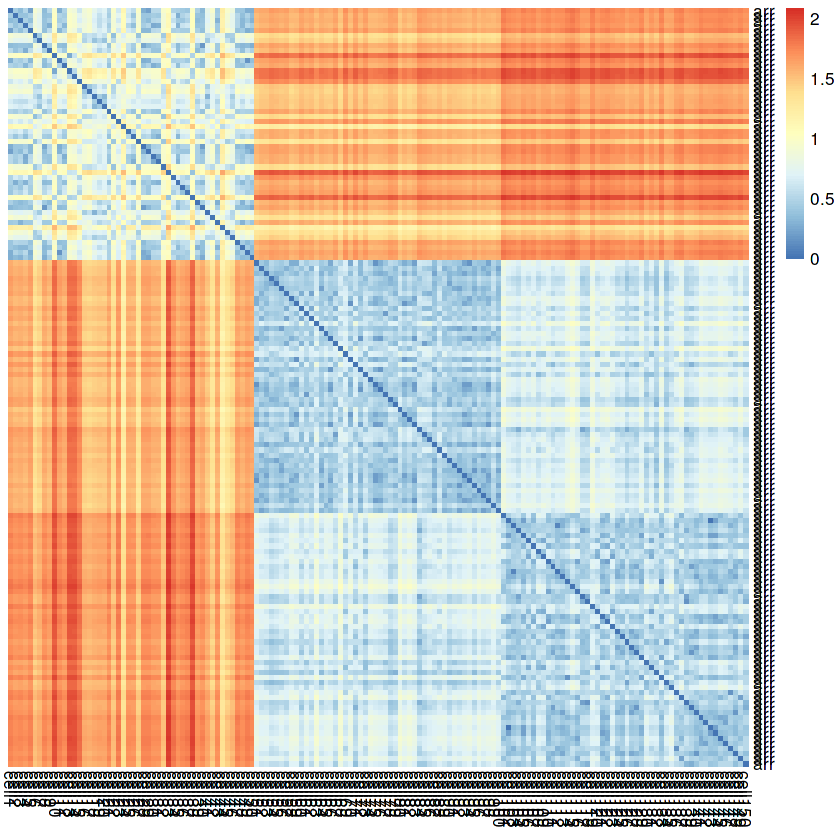

In [5]:
# 高维距离矩阵
getDist_High=function(dt.logcpm){
  df.dist=NULL;
  for(i in 1:ncol(dt.logcpm)){
    arr=c()
    for(j in 1:ncol(dt.logcpm)){
      arr=c(arr,dist(dt.logcpm[,i], dt.logcpm[,j]) )
    }
    names(arr)=colnames(dt.logcpm)
    df.dist=rbind(df.dist, arr)
  }
  df.dist
}
df.dist=getDist_High(dt.logcpm)
dim(df.dist)
library(pheatmap)
pheatmap(df.dist, cluster_rows = F, cluster_cols = F)

## dist to p

,cell1,cell2,cell3,cell4,cell5
arr,0.0000000,0.6951899,0.8037937,0.6142767,0.9146261
arr,0.6951899,0.0000000,0.7483931,0.7370899,0.6485985
arr,0.8037937,0.7483931,0.0000000,0.6572235,0.7824644
arr,0.6142767,0.7370899,0.6572235,0.0000000,0.5998605
arr,0.9146261,0.6485985,0.7824644,0.5998605,0.0000000


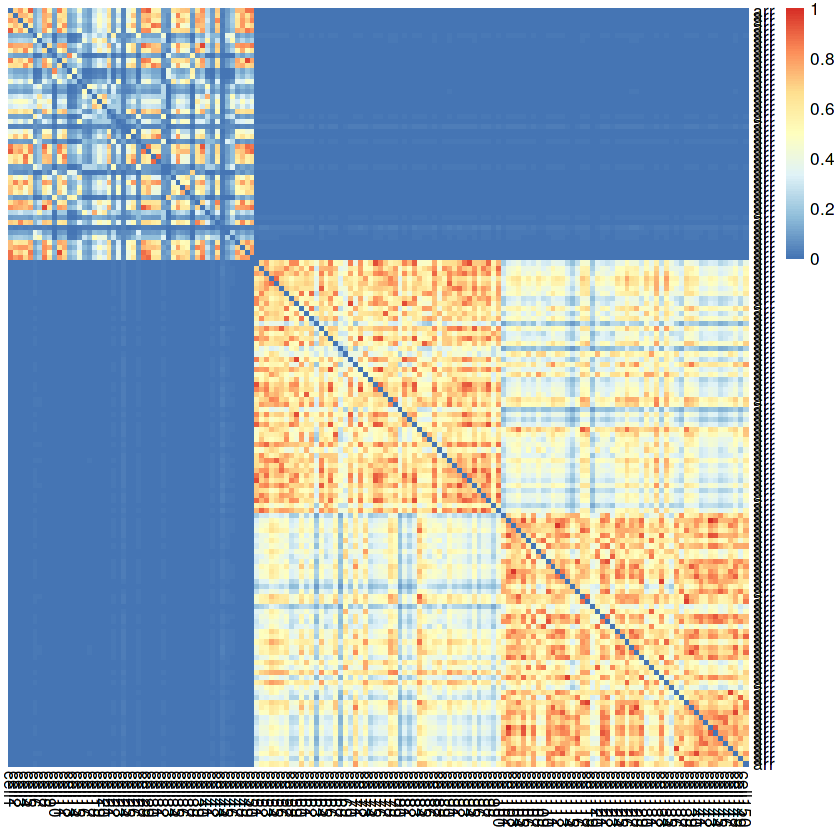

In [80]:
# dist to p: pij=(pi|j+pj|i)/2; 
getDist2P_High=function(df.dist){
  n=nrow(df.dist)
  df.p=apply(df.dist, 2, function(x){
    exp(-x^2/2/var(x))
  })
 diag(df.p)=0
 df.p=apply(df.p, 2, function(x){ ## 加上这个，很多p就很小了
     #x/sum(x)
     x
  })
    
  #dim(df.p)
  #df.p[1:5,1:5]
  for(x in 1:n){
    for(y in 1:n){
      if(x>y){
        df.p[x,y]=(df.p[x,y]+df.p[y,x])/2
      }else if(x==y){
        df.p[x,y]=0
      }
    }
  }
  ## 
  for(x in 1:n){
    for(y in 1:n){
      if(x<y){
        df.p[x,y]=df.p[y,x]
      }
    }
  }
  #
  df.p
}
#
df.p=getDist2P_High(df.dist)
df.p[1:5,1:5]
pheatmap(df.p, cluster_rows = F, cluster_cols = F)

# 低维空间

## 随机初始化

cell1     cell2     cell3     cell4     cell5     cell6 
-6.141011 14.414269  7.851848 14.070772  5.811402 16.717122

cell1 
-6.141011

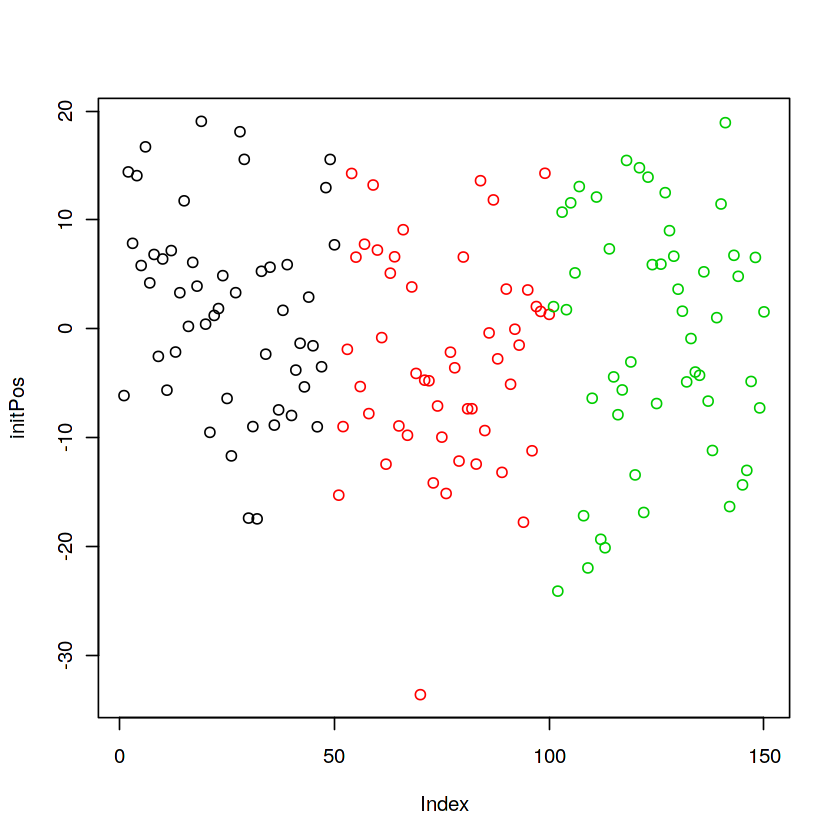

In [7]:
############
# for low dimensional data
# 起始随机化位置
init=function(){
  x=rnorm(150, 0, 10)
  nm=paste0('cell',1:150)
  names(x)=nm
  x
}
initPos=init()
head(initPos)
initPos[1]
#hist(initPos, n=100)
#plot(initPos, col=iris[,5])
plot(initPos, col=iris[,5])

## data to dist

[1] 150 150

arr,0.0000,422.5195379,195.800093,408.5161665,142.860163
arr,422.5195,0.0000000,43.065375,0.1179903,74.009331
arr,195.8001,43.0653749,0.000000,38.6750186,4.163421
arr,408.5162,0.1179903,38.675019,0.0000000,68.217200
arr,142.8602,74.0093310,4.163421,68.2171998,0.000000
arr,522.4942,5.3031294,78.593081,7.0031664,118.934730


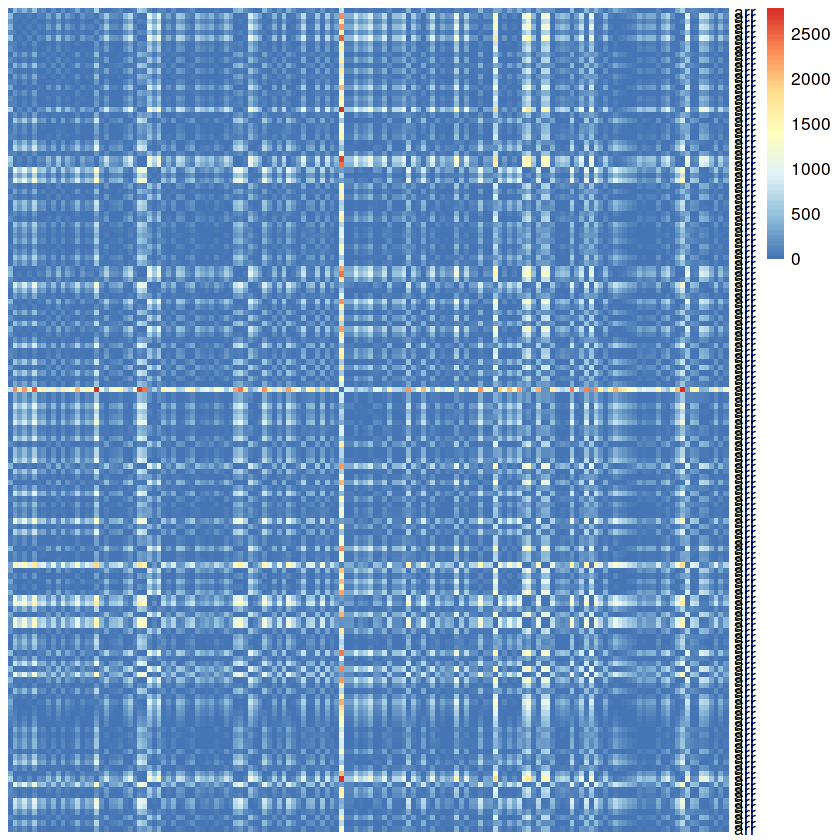

In [8]:
# 一维空间: 距离矩阵
getDist_Low=function(dt){
  getDist_High( t(data.frame(L=unname(dt))) )
}
dist.Low=getDist_Low(initPos)
dim(dist.Low)
head(dist.Low[,1:5]) # 已经对称了
pheatmap(dist.Low, cluster_rows = F, cluster_cols = F)

## dist to p

arr,0.000000e+00,4.065667e-09,1.893175e-08,4.349174e-09,3.556185e-08
arr,4.065667e-09,0.000000e+00,3.911446e-07,7.158523e-04,1.324877e-07
arr,1.893175e-08,3.911446e-07,0.000000e+00,4.849272e-07,3.958849e-05
arr,4.349174e-09,7.158523e-04,4.849272e-07,0.000000e+00,1.559361e-07
arr,3.556185e-08,1.324877e-07,3.958849e-05,1.559361e-07,0.000000e+00


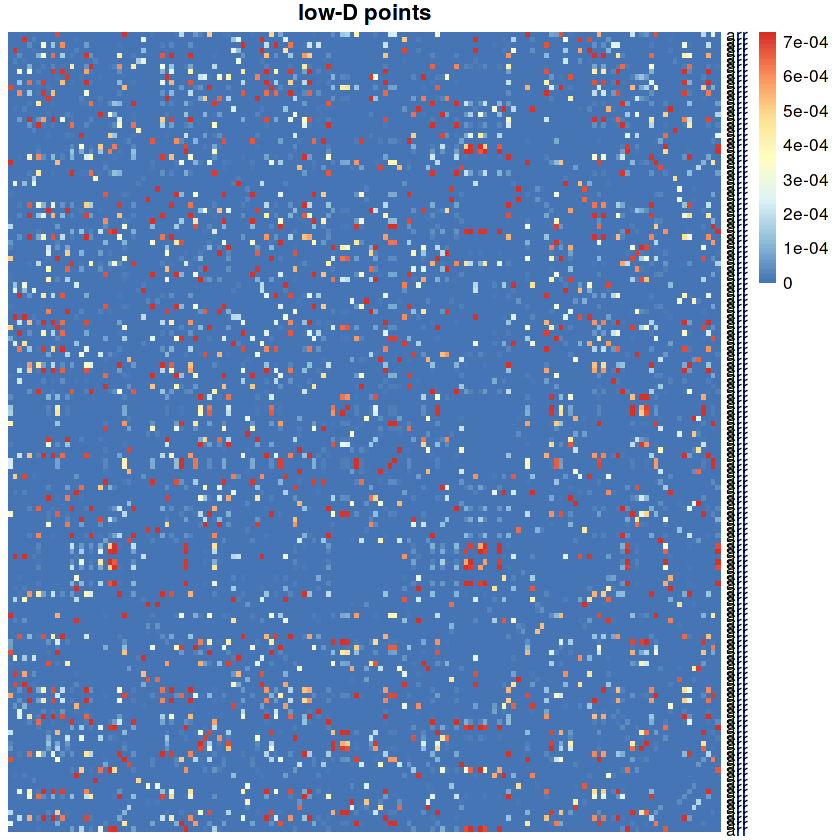

In [9]:
# 一维空间: dist 2 p
getDist2P_Low=function(df.dist){
  df.p=apply(df.dist, 2, function(x){
    (1+x^2)^-1
  })
  #
  n=nrow(df.dist)
  for(x in 1:n){
    for(y in 1:n){
      if(x==y){
        df.p[x,y]=0
      }
    }
  }
  #
  df.p=df.p/sum(df.p)
  df.p
}
df.p_low=getDist2P_Low(dist.Low)
df.p_low[1:5,1:5]
pheatmap(df.p_low, cluster_rows = F, cluster_cols = F, main="low-D points")

# KL 熵

In [10]:
#
get_C=function(dfH, dfL){
  n=nrow(dfH)
  C=0
  for(i in 1:n){
    for(j in 1:n){
      if(i==j) {next; }
      p1=as.numeric( dfH[i,j] )
      q1=as.numeric( dfL[i,j] )
      C=C+p1*log(p1/q1)
    }
  }
  return(C)
}
#
df.p[1:5,1:5]
df.p_low[1:5,1:5]

C1=get_C(df.p, df.p_low); C1

,cell1,cell2,cell3,cell4,cell5
arr,0.0000000,0.6951899,0.8037937,0.6142767,0.9146261
arr,0.6951899,0.0000000,0.7483931,0.7370899,0.6485985
arr,0.8037937,0.7483931,0.0000000,0.6572235,0.7824644
arr,0.6142767,0.7370899,0.6572235,0.0000000,0.5998605
arr,0.9146261,0.6485985,0.7824644,0.5998605,0.0000000


arr,0.000000e+00,4.065667e-09,1.893175e-08,4.349174e-09,3.556185e-08
arr,4.065667e-09,0.000000e+00,3.911446e-07,7.158523e-04,1.324877e-07
arr,1.893175e-08,3.911446e-07,0.000000e+00,4.849272e-07,3.958849e-05
arr,4.349174e-09,7.158523e-04,4.849272e-07,0.000000e+00,1.559361e-07
arr,3.556185e-08,1.324877e-07,3.958849e-05,1.559361e-07,0.000000e+00


[1] 90431.92

## 迭代

In [11]:
inter=function(initPos, cid, delta){
  initPosU=initPos
  initPosD=initPos
  initPosU[cid]=initPosU[cid]+delta
  initPosD[cid]=initPosD[cid]-delta
  #
  dist1=getDist_Low(initPos)
  p1=getDist2P_Low(dist1)
  C1=get_C(df.p, p1);
  #
  distU=getDist_Low(initPosU)
  pU=getDist2P_Low(distU)
  CU=get_C(df.p, pU);
  #
  distD=getDist_Low(initPosD)
  pD=getDist2P_Low(distD)
  CD=get_C(df.p, pD);
  #
  C1=get_C(df.p, pU);
  return( c(CU-C1, CD-C1, C1, p1) )
}

## delta=5

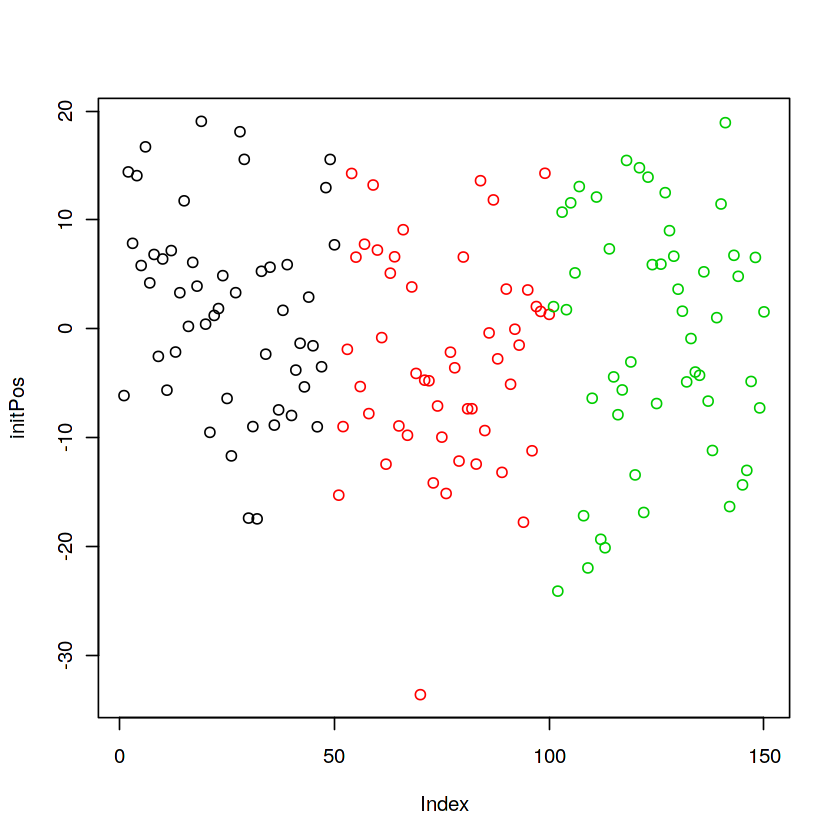

In [12]:
plot(initPos, col=iris[,5])

2020-08-06 11:33:08; interation: 1

- - >iter=1; Move obs number=76; C=86399.4799754957

2020-08-06 11:33:51; interation: 2

- - >iter=2; Move obs number=82; C=81885.8914848993

2020-08-06 11:34:34; interation: 3

- - >iter=3; Move obs number=92; C=77078.2008202913

2020-08-06 11:35:18; interation: 4

- - >iter=4; Move obs number=94; C=72842.0860705704

2020-08-06 11:36:01; interation: 5

- - >iter=5; Move obs number=115; C=70732.3502620022



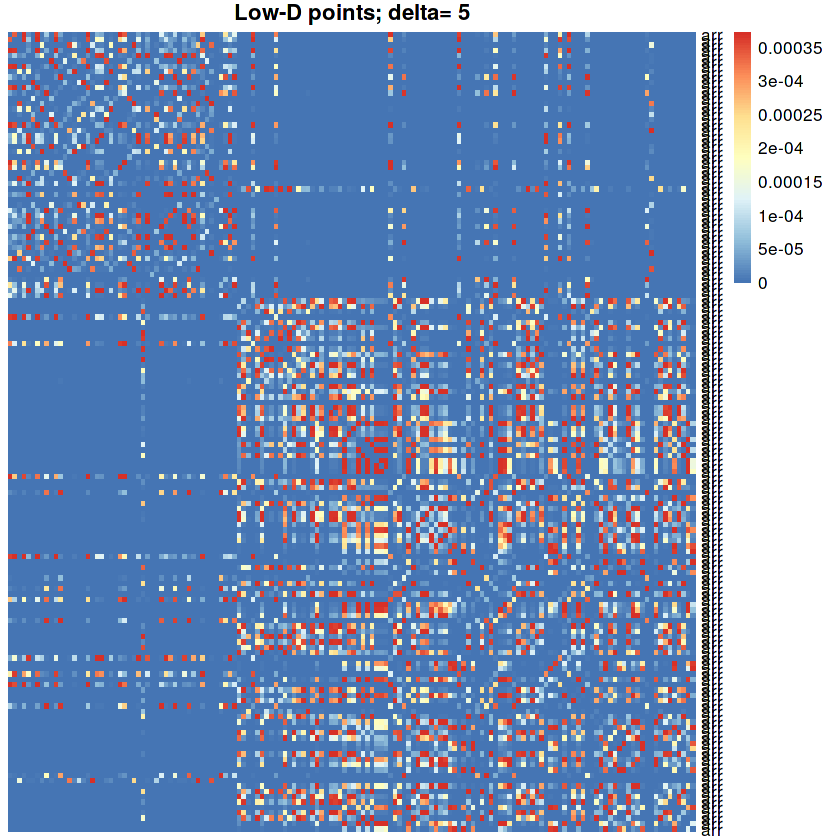

In [13]:
# 开始迭代, 每次迭代都对每个点尝试左右移动一下，看能否降低熵
delta=5
#
for(i in 1:5){
  #message(paste('interation: ',i) )
  message(Sys.time(), '; interation: ',i)
  x=0;
  for(obsN in 1:150){
    cid=paste0('cell', obsN)
    rs=inter(initPos, cid, delta)
    if(rs[1]>=0 & rs[2]>=0){ #next point
      next;
    }else if(rs[1]>rs[2]){  #down
      initPos[cid]=initPos[cid]-delta
    }else{  #up
      initPos[cid]=initPos[cid]+delta
    }
    x=x+1; #if(x%%10==0){print(paste('iter =',i, '- - >obs number: ',x, cid) )}
  }
  message('- - >iter=',i, '; Move obs number=',x, '; C=', rs[3])
}
p1=getDist2P_Low( getDist_Low(initPos) )
pheatmap(p1, cluster_rows = F, cluster_cols = F, main=paste('Low-D points; delta=', delta))

2020-08-06 11:36:44; interation: 1

- - >iter=1; Move obs number=106; C=67904.3624910577

2020-08-06 11:37:27; interation: 2

- - >iter=2; Move obs number=122; C=66757.5236433559

2020-08-06 11:38:11; interation: 3

- - >iter=3; Move obs number=131; C=65683.9478860446

2020-08-06 11:38:54; interation: 4

- - >iter=4; Move obs number=133; C=66120.3836041531

2020-08-06 11:39:37; interation: 5

- - >iter=5; Move obs number=133; C=65493.3276943099



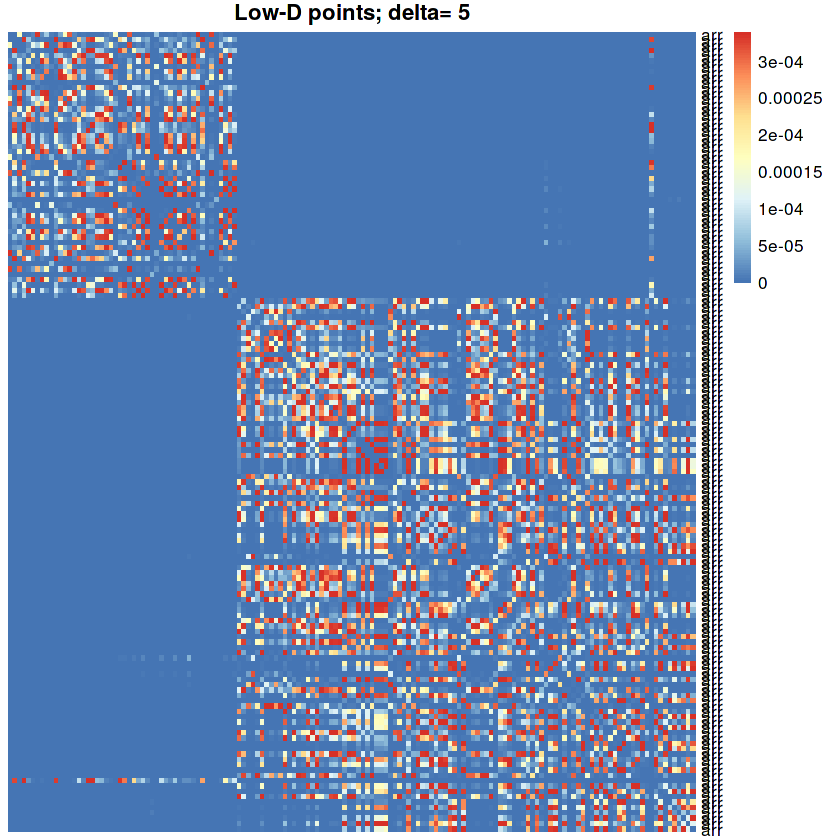

In [14]:
# 开始迭代, 每次迭代都对每个点尝试左右移动一下，看能否降低熵
delta=5
#
for(i in 1:5){
  #message(paste('interation: ',i) )
  message(Sys.time(), '; interation: ',i)
  x=0;
  for(obsN in 1:150){
    cid=paste0('cell', obsN)
    rs=inter(initPos, cid, delta)
    if(rs[1]>=0 & rs[2]>=0){ #next point
      next;
    }else if(rs[1]>rs[2]){  #down
      initPos[cid]=initPos[cid]-delta
    }else{  #up
      initPos[cid]=initPos[cid]+delta
    }
    x=x+1; #if(x%%10==0){print(paste('iter =',i, '- - >obs number: ',x, cid) )}
  }
  message('- - >iter=',i, '; Move obs number=',x, '; C=', rs[3])
}
p1=getDist2P_Low( getDist_Low(initPos) )
pheatmap(p1, cluster_rows = F, cluster_cols = F, main=paste('Low-D points; delta=', delta))

## delta=3

2020-08-06 11:40:21; interation: 1

- - >iter=1; Move obs number=94; C=60664.565732262

2020-08-06 11:41:04; interation: 2

- - >iter=2; Move obs number=136; C=60226.485814863

2020-08-06 11:41:47; interation: 3

- - >iter=3; Move obs number=144; C=60383.0755468046

2020-08-06 11:42:30; interation: 4

- - >iter=4; Move obs number=146; C=60363.3050538106

2020-08-06 11:43:13; interation: 5

- - >iter=5; Move obs number=150; C=60363.3050538106

2020-08-06 11:43:56; interation: 6

- - >iter=6; Move obs number=150; C=60363.3050538106

2020-08-06 11:44:40; interation: 7

- - >iter=7; Move obs number=150; C=60363.3050538106

2020-08-06 11:45:23; interation: 8

- - >iter=8; Move obs number=150; C=60363.3050538106

2020-08-06 11:46:06; interation: 9

- - >iter=9; Move obs number=150; C=60363.3050538107

2020-08-06 11:46:49; interation: 10

- - >iter=10; Move obs number=150; C=60363.3050538106



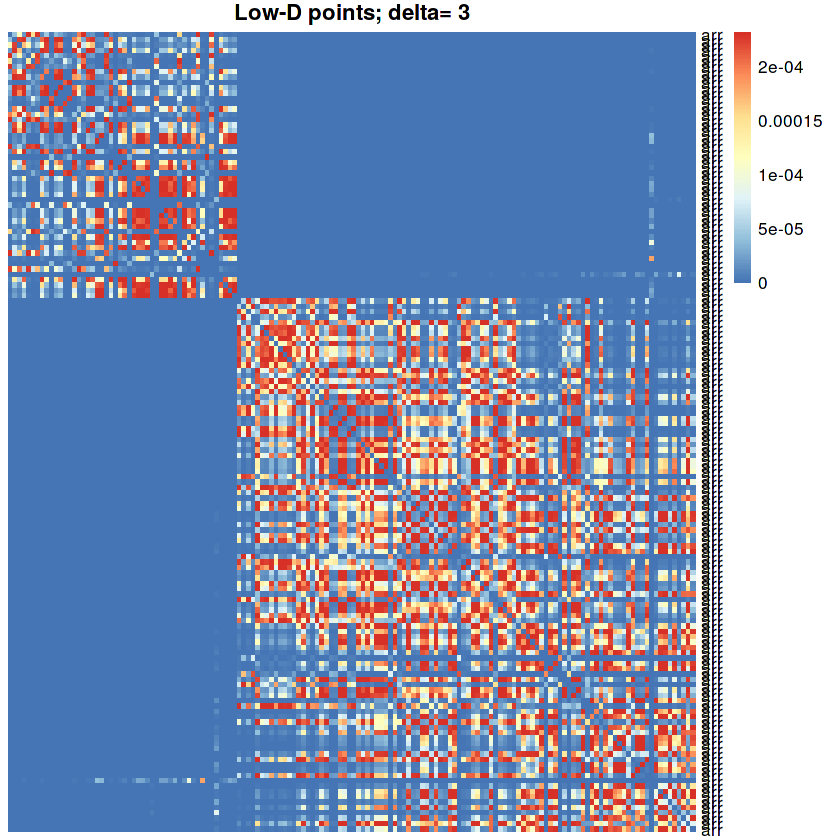

In [15]:
# 开始迭代, 每次迭代都对每个点尝试左右移动一下，看能否降低熵
delta=3
#
for(i in 1:10){
  #message(paste('interation: ',i) )
  message(Sys.time(), '; interation: ',i)
  x=0;
  for(obsN in 1:150){
    cid=paste0('cell', obsN)
    rs=inter(initPos, cid, delta)
    if(rs[1]>=0 & rs[2]>=0){ #next point
      next;
    }else if(rs[1]>rs[2]){  #down
      initPos[cid]=initPos[cid]-delta
    }else{  #up
      initPos[cid]=initPos[cid]+delta
    }
    x=x+1;
  }
  message('- - >iter=',i, '; Move obs number=',x, '; C=', rs[3])
}
p1=getDist2P_Low( getDist_Low(initPos) )
pheatmap(p1, cluster_rows = F, cluster_cols = F, main=paste('Low-D points; delta=', delta))

## delta=1

2020-08-06 11:47:33; interation: 1

- - >iter=1; Move obs number=94; C=57874.6710240982

2020-08-06 11:48:16; interation: 2

- - >iter=2; Move obs number=100; C=56402.039579672

2020-08-06 11:48:59; interation: 3

- - >iter=3; Move obs number=109; C=55535.8724866257

2020-08-06 11:49:42; interation: 4

- - >iter=4; Move obs number=111; C=55038.2784495339

2020-08-06 11:50:26; interation: 5

- - >iter=5; Move obs number=126; C=54802.4309620912

2020-08-06 11:51:09; interation: 6

- - >iter=6; Move obs number=127; C=54648.7801810924

2020-08-06 11:51:52; interation: 7

- - >iter=7; Move obs number=130; C=54477.9832995904

2020-08-06 11:52:35; interation: 8

- - >iter=8; Move obs number=134; C=54362.1533053667

2020-08-06 11:53:18; interation: 9

- - >iter=9; Move obs number=132; C=54266.4725839029

2020-08-06 11:54:01; interation: 10

- - >iter=10; Move obs number=135; C=54189.5804496438



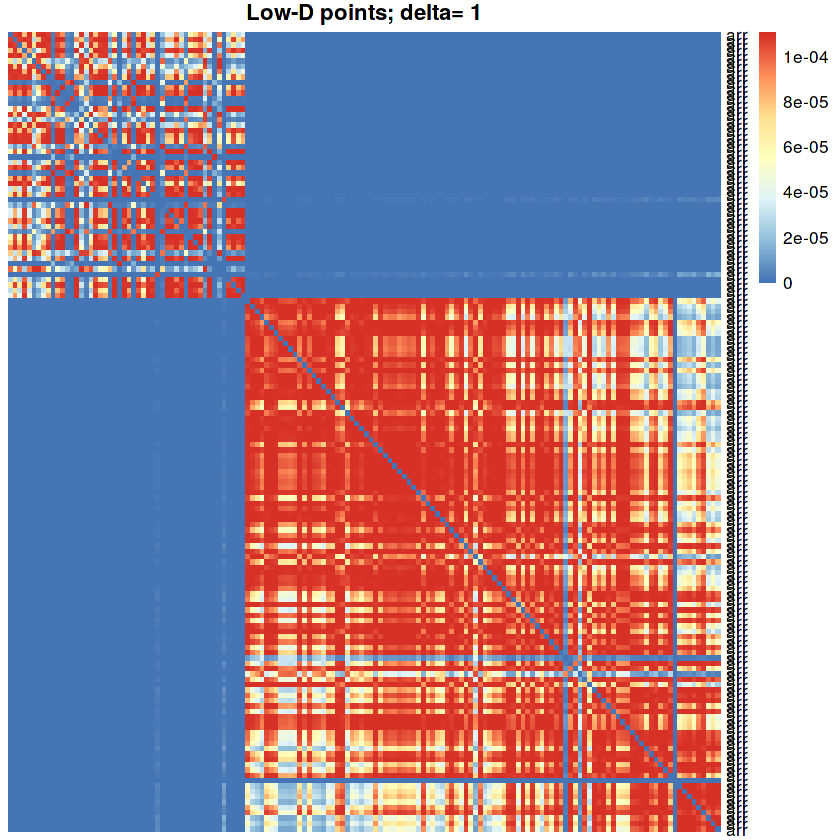

In [16]:
# 开始迭代, 每次迭代都对每个点尝试左右移动一下，看能否降低熵
delta=1
#
for(i in 1:10){
  #message(paste('interation: ',i) )
  message(Sys.time(), '; interation: ',i)
  x=0;
  for(obsN in 1:150){
    cid=paste0('cell', obsN)
    rs=inter(initPos, cid, delta)
    if(rs[1]>=0 & rs[2]>=0){ #next point
      next;
    }else if(rs[1]>rs[2]){  #down
      initPos[cid]=initPos[cid]-delta
    }else{  #up
      initPos[cid]=initPos[cid]+delta
    }
    x=x+1;
  }
  message('- - >iter=',i, '; Move obs number=',x, '; C=', rs[3])
}
p1=getDist2P_Low( getDist_Low(initPos) )
pheatmap(p1, cluster_rows = F, cluster_cols = F, main=paste('Low-D points; delta=', delta))

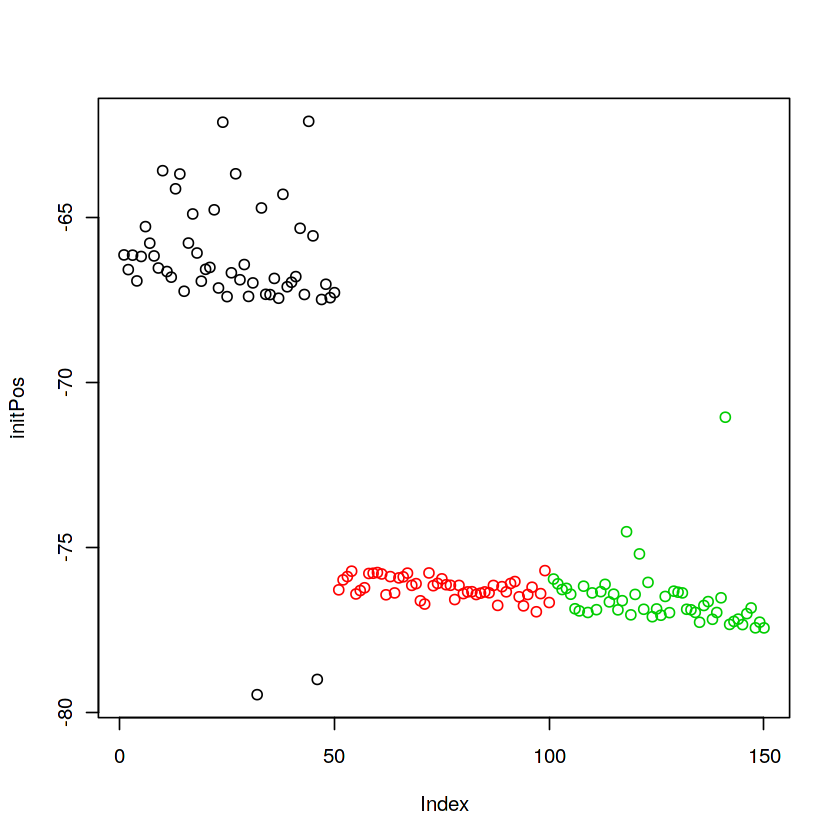

In [17]:
plot(initPos, col=iris[,5])

## delta=0.5

2020-08-06 11:54:45; interation: 1

- - >iter=1; Move obs number=95; C=53847.6696749018

2020-08-06 11:55:28; interation: 2

- - >iter=2; Move obs number=106; C=53715.2595572303

2020-08-06 11:56:11; interation: 3

- - >iter=3; Move obs number=97; C=53619.0108389035

2020-08-06 11:56:54; interation: 4

- - >iter=4; Move obs number=112; C=53568.9467012902

2020-08-06 11:57:38; interation: 5

- - >iter=5; Move obs number=119; C=53520.6943292517

2020-08-06 11:58:21; interation: 6

- - >iter=6; Move obs number=131; C=53486.8660679833

2020-08-06 11:59:04; interation: 7

- - >iter=7; Move obs number=119; C=53430.9013205782

2020-08-06 11:59:47; interation: 8

- - >iter=8; Move obs number=133; C=53419.0920596635

2020-08-06 12:00:30; interation: 9

- - >iter=9; Move obs number=131; C=53431.7191283272

2020-08-06 12:01:14; interation: 10

- - >iter=10; Move obs number=136; C=53417.4510115291



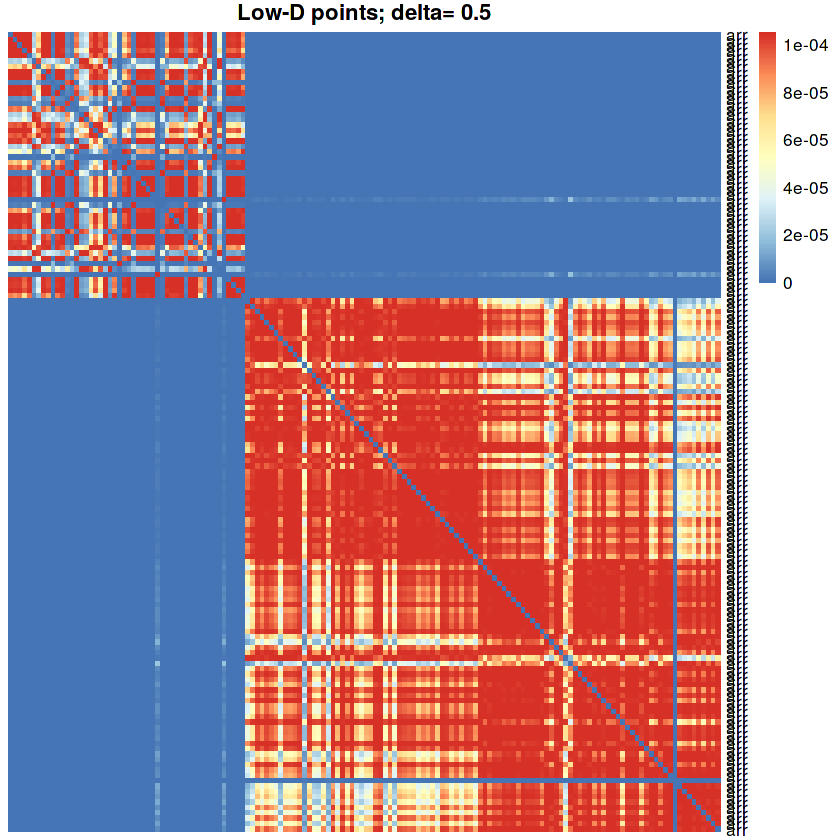

In [18]:
# 开始迭代, 每次迭代都对每个点尝试左右移动一下，看能否降低熵
delta=0.5
#
for(i in 1:10){
  #message(paste('interation: ',i) )
  message(Sys.time(), '; interation: ',i)
  x=0;
  for(obsN in 1:150){
    cid=paste0('cell', obsN)
    rs=inter(initPos, cid, delta)
    if(rs[1]>=0 & rs[2]>=0){ #next point
      next;
    }else if(rs[1]>rs[2]){  #down
      initPos[cid]=initPos[cid]-delta
    }else{  #up
      initPos[cid]=initPos[cid]+delta
    }
    x=x+1;
  }
  message('- - >iter=',i, '; Move obs number=',x, '; C=', rs[3])
}
p1=getDist2P_Low( getDist_Low(initPos) )
pheatmap(p1, cluster_rows = F, cluster_cols = F, main=paste('Low-D points; delta=', delta))

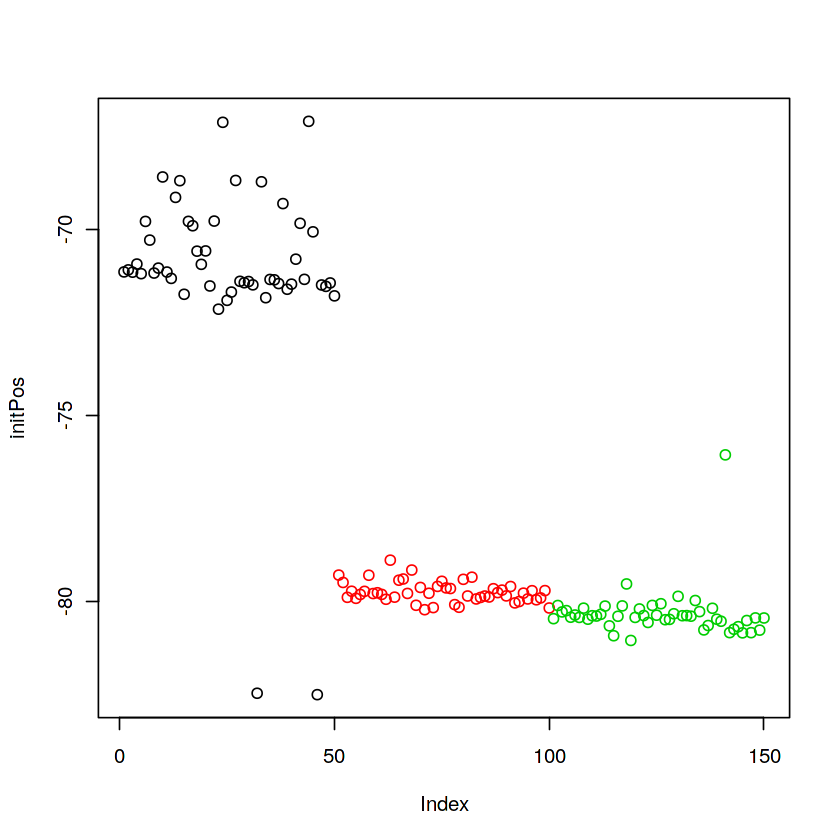

In [19]:
plot(initPos, col=iris[,5])

2020-08-06 12:01:57; interation: 1

- - >iter=1; Move obs number=137; C=53393.4281934809

2020-08-06 12:02:40; interation: 2

- - >iter=2; Move obs number=130; C=53370.7497518081

2020-08-06 12:03:24; interation: 3

- - >iter=3; Move obs number=138; C=53340.90299624

2020-08-06 12:04:07; interation: 4

- - >iter=4; Move obs number=134; C=53337.0244370526

2020-08-06 12:04:50; interation: 5

- - >iter=5; Move obs number=137; C=53355.2091295826

2020-08-06 12:05:33; interation: 6

- - >iter=6; Move obs number=140; C=53351.9112040977

2020-08-06 12:06:16; interation: 7

- - >iter=7; Move obs number=138; C=53346.0017284201

2020-08-06 12:07:00; interation: 8

- - >iter=8; Move obs number=138; C=53330.0538081914

2020-08-06 12:07:43; interation: 9

- - >iter=9; Move obs number=144; C=53313.1908987673

2020-08-06 12:08:26; interation: 10

- - >iter=10; Move obs number=132; C=53292.6579998661



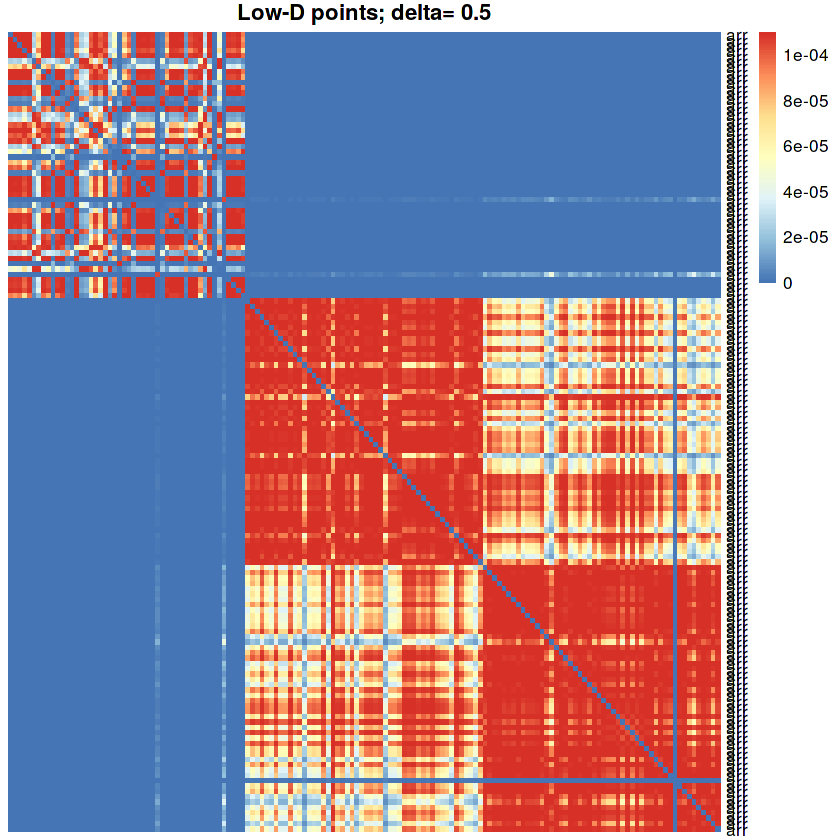

In [20]:
# 开始迭代, 每次迭代都对每个点尝试左右移动一下，看能否降低熵
delta=0.5
#
for(i in 1:10){
  #message(paste('interation: ',i) )
  message(Sys.time(), '; interation: ',i)
  x=0;
  for(obsN in 1:150){
    cid=paste0('cell', obsN)
    rs=inter(initPos, cid, delta)
    if(rs[1]>=0 & rs[2]>=0){ #next point
      next;
    }else if(rs[1]>rs[2]){  #down
      initPos[cid]=initPos[cid]-delta
    }else{  #up
      initPos[cid]=initPos[cid]+delta
    }
    x=x+1;
  }
  message('- - >iter=',i, '; Move obs number=',x, '; C=', rs[3])
}
p1=getDist2P_Low( getDist_Low(initPos) )
pheatmap(p1, cluster_rows = F, cluster_cols = F, main=paste('Low-D points; delta=', delta))

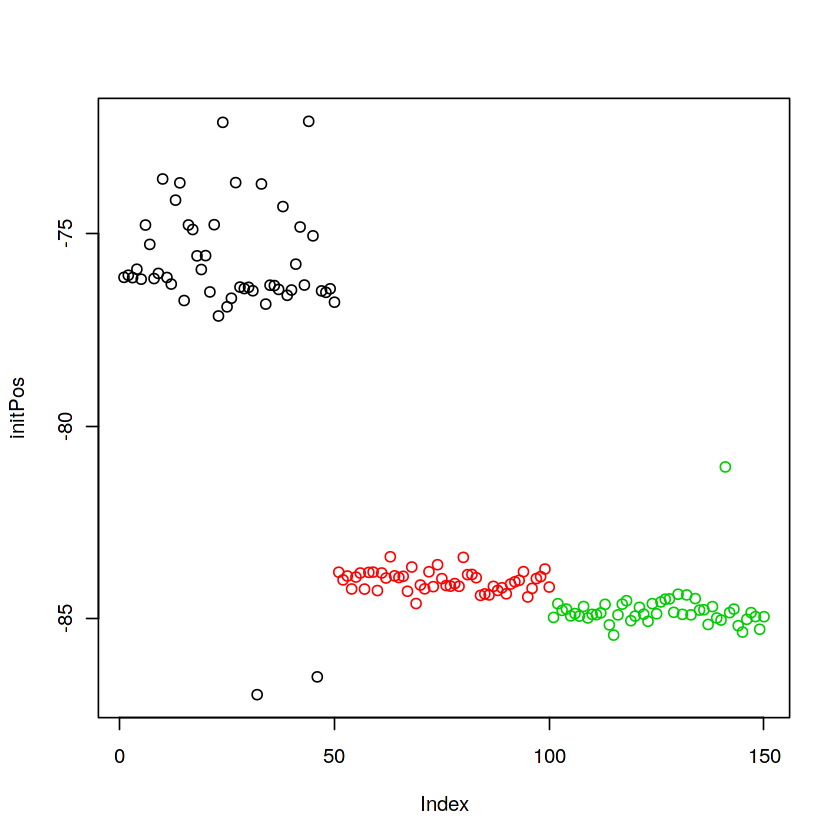

In [21]:
plot(initPos, col=iris[,5])

## delta=5

2020-08-06 12:09:10; interation: 1

- - >iter=1; Move obs number=148; C=54126.2234769507

2020-08-06 12:09:53; interation: 2

- - >iter=2; Move obs number=148; C=54025.8196658862

2020-08-06 12:10:36; interation: 3

- - >iter=3; Move obs number=150; C=54025.8196658862

2020-08-06 12:11:19; interation: 4

- - >iter=4; Move obs number=150; C=54025.8196658862

2020-08-06 12:12:02; interation: 5

- - >iter=5; Move obs number=150; C=54025.8196658862

2020-08-06 12:12:45; interation: 6

- - >iter=6; Move obs number=150; C=54025.8196658862

2020-08-06 12:13:29; interation: 7

- - >iter=7; Move obs number=150; C=54025.8196658862

2020-08-06 12:14:12; interation: 8

- - >iter=8; Move obs number=150; C=54025.8196658862

2020-08-06 12:14:55; interation: 9

- - >iter=9; Move obs number=150; C=54025.8196658862

2020-08-06 12:15:38; interation: 10

- - >iter=10; Move obs number=150; C=54025.8196658862



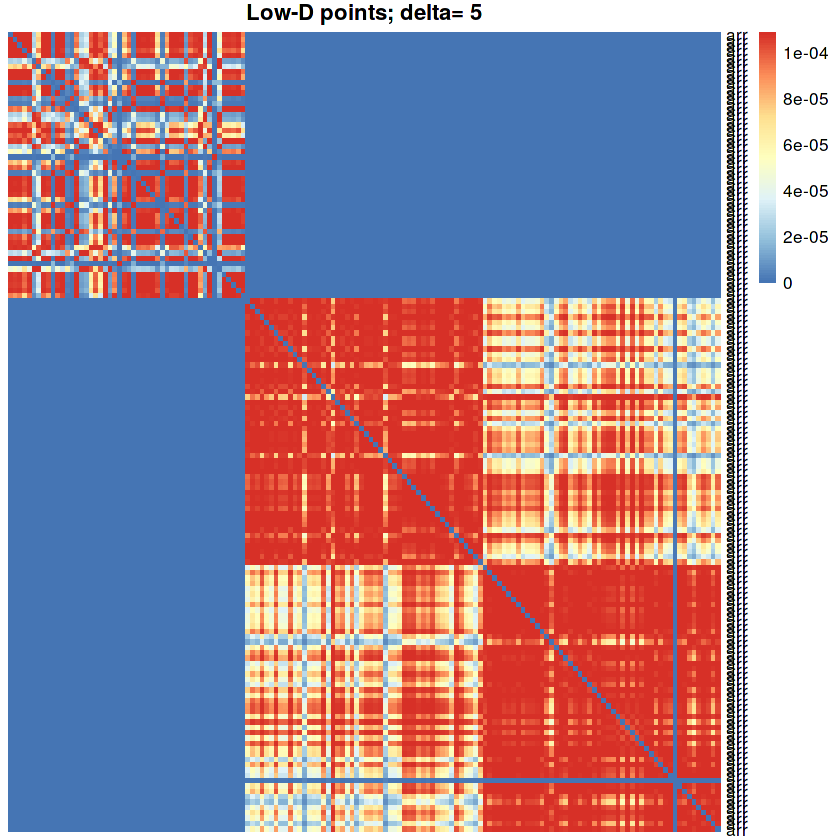

In [22]:
# 开始迭代, 每次迭代都对每个点尝试左右移动一下，看能否降低熵
delta=5
#
for(i in 1:10){
  #message(paste('interation: ',i) )
  message(Sys.time(), '; interation: ',i)
  x=0;
  for(obsN in 1:150){
    cid=paste0('cell', obsN)
    rs=inter(initPos, cid, delta)
    if(rs[1]>=0 & rs[2]>=0){ #next point
      next;
    }else if(rs[1]>rs[2]){  #down
      initPos[cid]=initPos[cid]-delta
    }else{  #up
      initPos[cid]=initPos[cid]+delta
    }
    x=x+1;
  }
  message('- - >iter=',i, '; Move obs number=',x, '; C=', rs[3])
}
p1=getDist2P_Low( getDist_Low(initPos) )
pheatmap(p1, cluster_rows = F, cluster_cols = F, main=paste('Low-D points; delta=', delta))

initPos_New=initPos

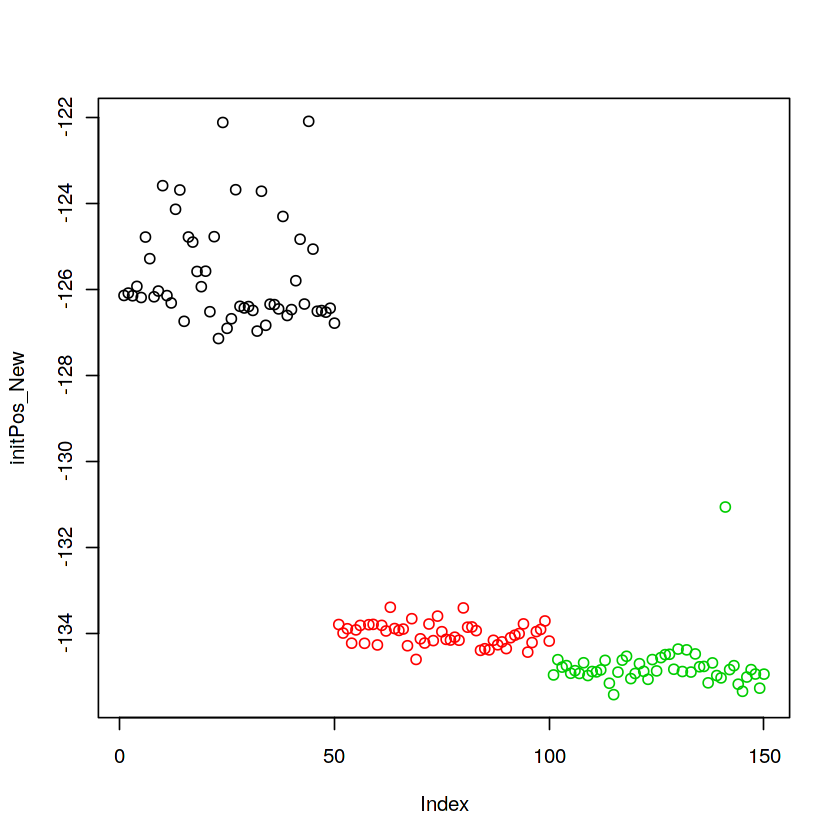

In [33]:
plot(initPos_New, col=iris[,5])

# 导数 derivative

In [23]:
derivativeAtCid=function(initPos, i, dfH, dfL){
    n=length(initPos)
    yi=initPos[paste0('cell', i)]
    s=0;
    for(j in 1:n){
        p=dfH[i,j];
        q=dfL[i,j];
        yj=initPos[paste0('cell',j)];
        d=( 1+(yi-yj)^2 )^-1;
        s=s+4*(p-q)*(yi-yj)*d
    }
    return(s)
}

In [24]:
der=derivativeAtCid(initPos, 1, df.p, df.p_low);der

arr 
13.23835

In [25]:
-4.5/13 #0.34

[1] -0.3461538

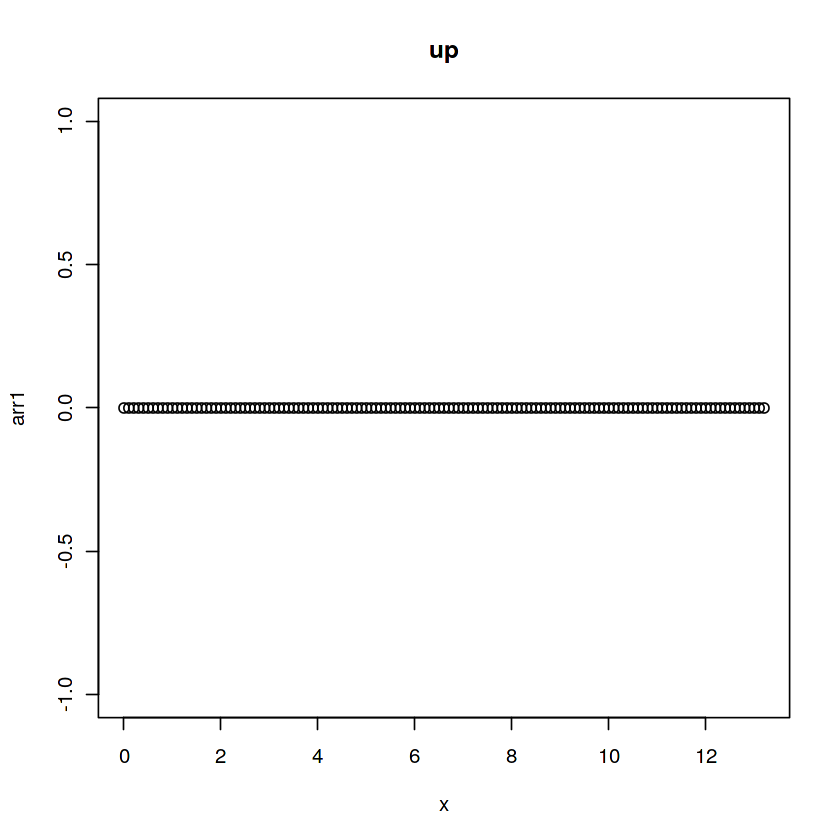

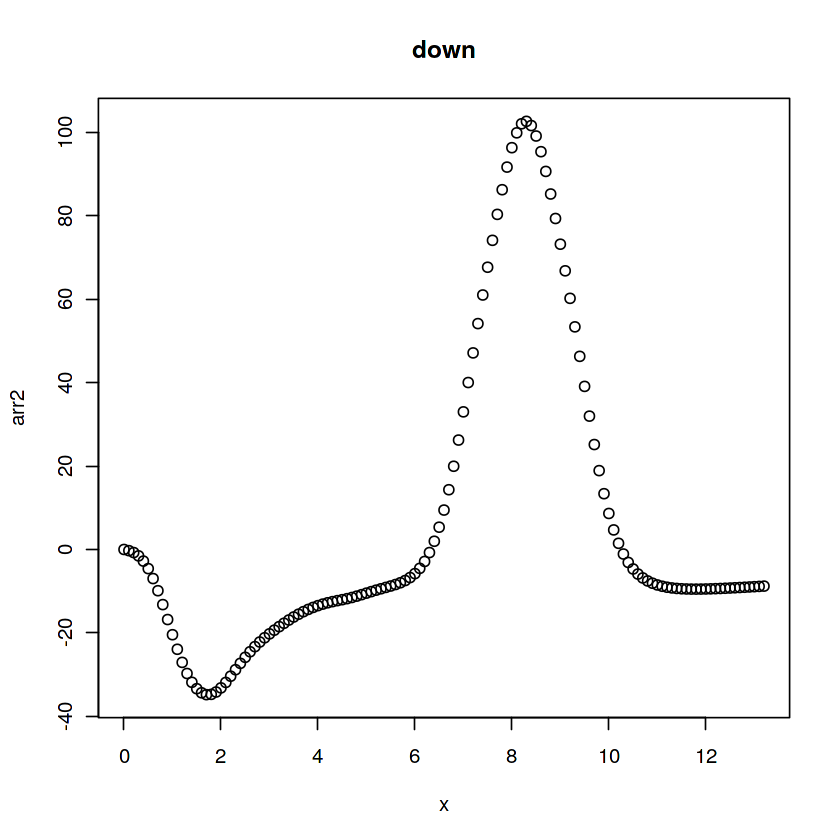

In [26]:
if(der>0)x=seq(0, der, 0.1)
if(der<0)x=seq(0, der, -0.1)
arr1=c()
arr2=c()
for(i in x){
    rs=inter(initPos, paste0('cell',1), delta=i);
    arr1=c(arr1, rs[1])
    arr2=c(arr2, rs[2])
}
plot(x, arr1, main='up')
plot(x, arr2, main='down')

## 用导数迭代

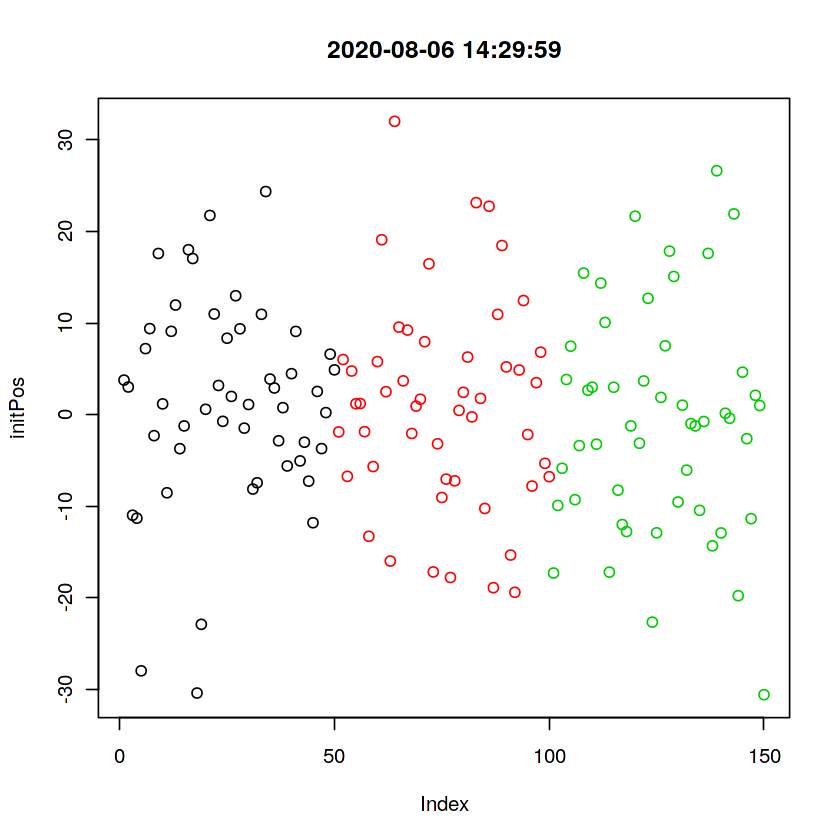

In [73]:
# 初始化位置
set.seed(2020)
initPos=init()
plot(initPos, col=iris[,5], main=Sys.time())

[1] 92099


I=10; - - > cid=cell150; ita=0.25;  C=73290.7975133584; 2020-08-06 14:30:04

I=20; - - > cid=cell150; ita=0.25;  C=73508.9834742755; 2020-08-06 14:30:06

I=30; - - > cid=cell150; ita=0.25;  C=72454.3041336419; 2020-08-06 14:30:08

I=40; - - > cid=cell150; ita=0.25;  C=73615.9349505292; 2020-08-06 14:30:10

I=50; - - > cid=cell150; ita=0.25;  C=72614.059031755; 2020-08-06 14:30:12

I=60; - - > cid=cell150; ita=0.25;  C=74053.1108198653; 2020-08-06 14:30:13

I=70; - - > cid=cell150; ita=0.25;  C=72665.110548711; 2020-08-06 14:30:15

I=80; - - > cid=cell150; ita=0.25;  C=71487.7528585286; 2020-08-06 14:30:17

I=90; - - > cid=cell150; ita=0.25;  C=72781.0387133862; 2020-08-06 14:30:19

I=100; - - > cid=cell150; ita=0.25;  C=73213.967382668; 2020-08-06 14:30:21

I=110; - - > cid=cell150; ita=0.25;  C=71740.1964442081; 2020-08-06 14:30:22

I=120; - - > cid=cell150; ita=0.25;  C=69140.067448641; 2020-08-06 14:30:24

I=130; - - > cid=cell150; ita=0.25;  C=71171.391818463; 2020-08-06 14:30:26



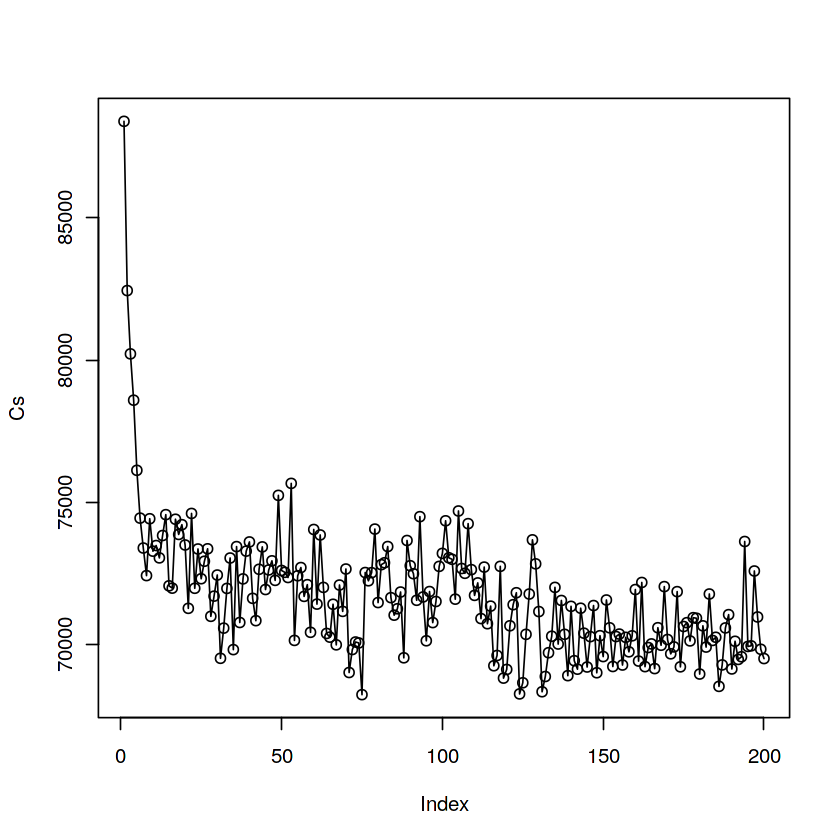

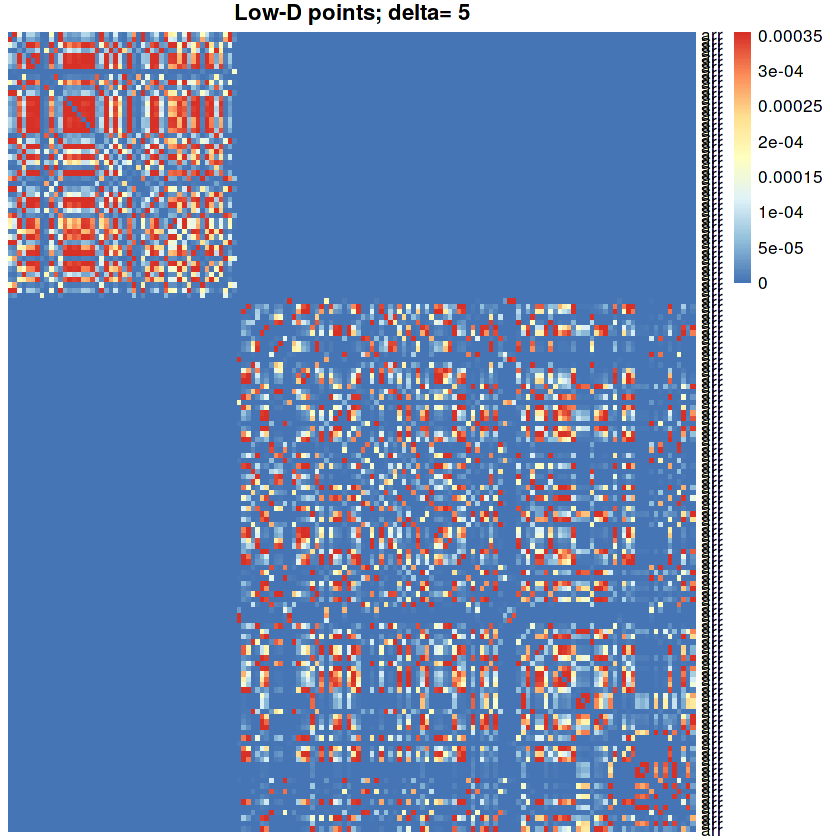

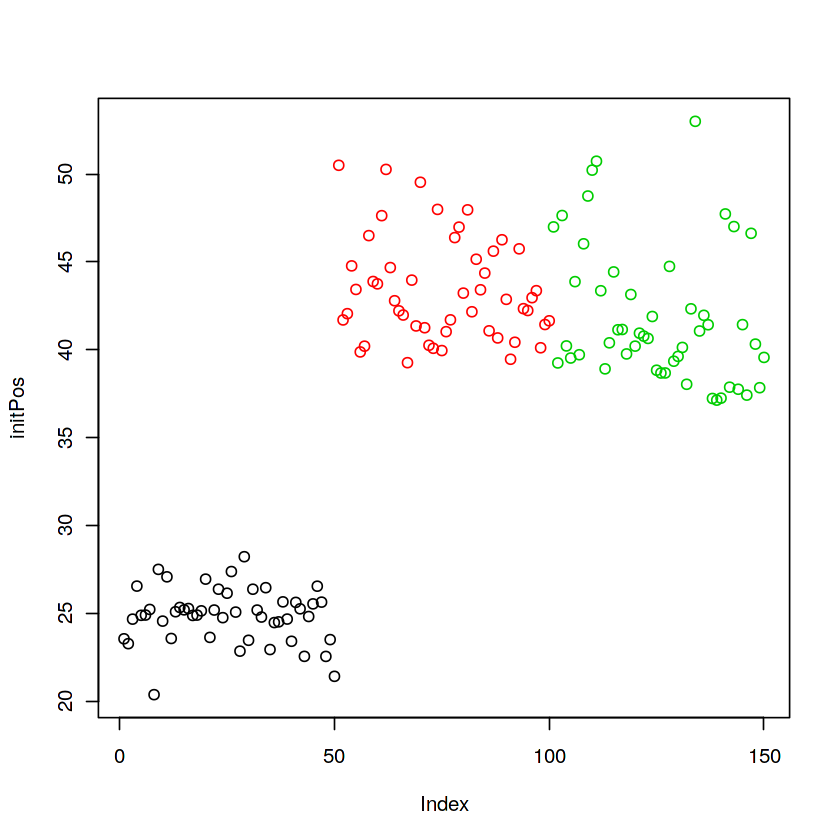

In [74]:
ita=0.25 # learning rate η

df.p_low = getDist2P_Low(getDist_Low(initPos))
C0 = get_C(df.p, df.p_low);
print(C0)

result=list('I'=1, 'C'=C0, 'initPos'=initPos)

Cs=c();
for(I in 1:200){
    for(i in 1:150){
        cid=paste0('cell',i);
        change=derivativeAtCid(initPos, i, df.p, df.p_low)
        initPos[cid]=initPos[cid]-ita*change;
    }
    
    # save C for this step
    df.p_low = getDist2P_Low(getDist_Low(initPos))
    C1 = get_C(df.p, df.p_low);
    #if(C0>C1){C0=C1}else{break;}
    if(I%%10==0){ message( 'I=',I, '; - - > cid=', cid,  '; ita=', ita, ';  C=', C1, '; ',Sys.time() ) }
    Cs=c(Cs, C1)
    # save the miminum C, and status
    if(result['C']>C1){
        result[['I']]=I
        result[['C']]=C1
        result[['initPos']]=initPos;
        #ita=ita*0.9
    }
}
plot( Cs, type="o")

#initPos=result[['initPos']]
p1=getDist2P_Low( getDist_Low(initPos) )
pheatmap(p1, cluster_rows = F, cluster_cols = F, main=paste('Low-D points; delta=', delta))

plot(initPos, col=iris[,5])

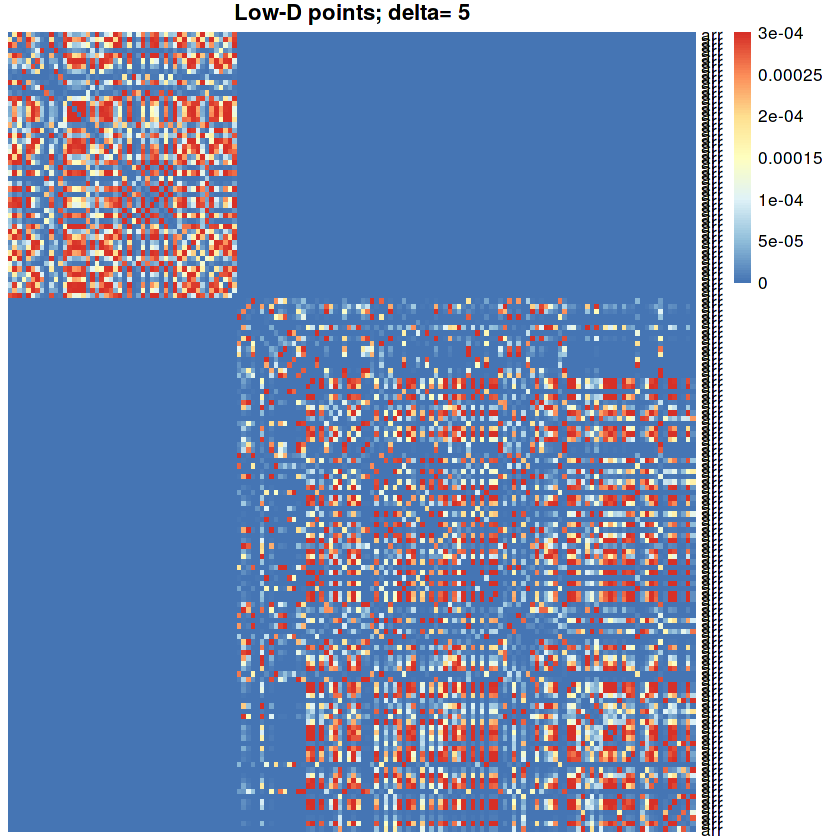

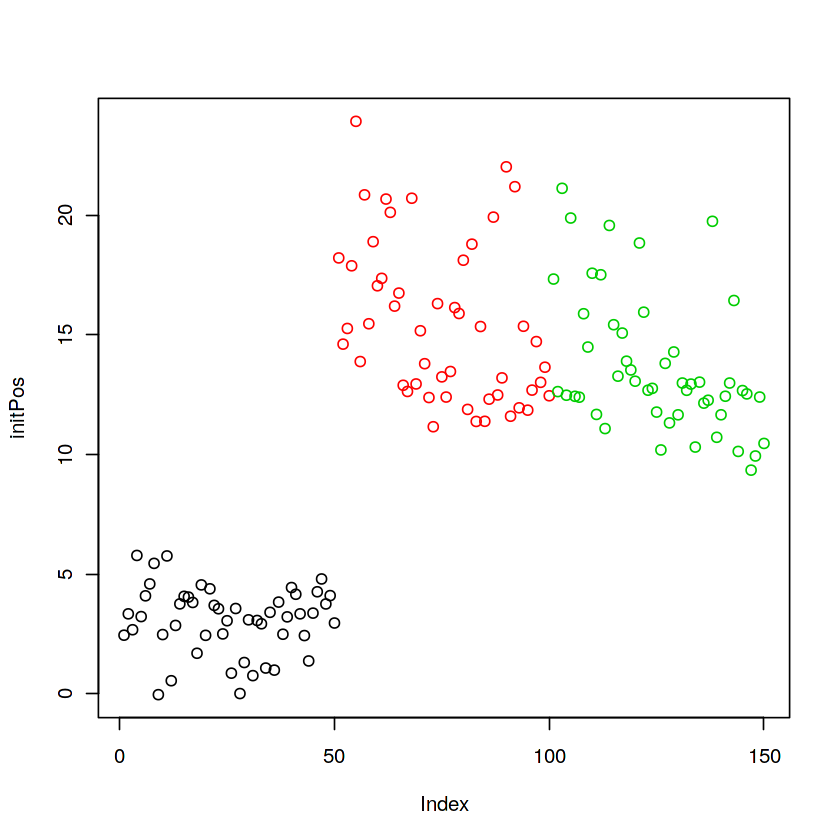

In [75]:
# the minimum C
initPos=result[['initPos']]
p1=getDist2P_Low( getDist_Low(initPos) )
pheatmap(p1, cluster_rows = F, cluster_cols = F, main=paste('Low-D points; delta=', delta))

plot(initPos, col=iris[,5])

# 推广到二维

In [76]:
head(iris)

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa
6,5.4,3.9,1.7,0.4,setosa


In [79]:
write.csv(iris, 'iris.csv', quote = F)

In [78]:
getwd()

[1] "/data/wangjl"